# Data Exploration

# Import Data

In [1]:
def analyzeQuantiles (data,):
    
    """"""""""""""""
    
    Receives:
            pandas dataframe
            
    Creates a df that analyzes outliers by creating 2 disparity features that measure the level of the outliers.
    The fist measure divides de 95% quantile by the 90% and the second divides the mean by the median
    
    Note: thresholds can be fyrther adjusted
    
    """""""""""""""""
    df_out = data
    #calculate the following quantiles [.25, .5, .75,0.9,0.95]
    quantile_disp = np.round(df_out.describe([.25, .5, .75,0.9,0.95]).T).iloc[:,:-1]
    #divide quantile 95 by 90  
    quantile_disp['disparity'] = (quantile_disp['95%'] / quantile_disp['90%']).replace(np.inf,0)
    #divide mean by median
    quantile_disp['mean_disp'] = (quantile_disp['mean'] / quantile_disp['50%']).replace(np.inf,0)

    quantile_disp = quantile_disp.sort_values(ascending=False,by = 'mean_disp')
    display(quantile_disp.iloc[:10])
    
    return(quantile_disp)

def replaceOutliers (data,upper_thresh, lower_thresh):
    """"""""""""""""
    
    Receives:
            pandas dataframe
            
    Replaces outliers with the nearest quantile, per example an observation of quantile 99 will be replaced by the quantile 90
    
    Note: thresholds can be fyrther adjusted
    
    """""""""""""""""
    df_out = data.copy()
    
    cols = df_out.select_dtypes(include = np.number).columns
    rem_cols = df_out.select_dtypes(exclude = np.number).columns
    #for each column
    for col in cols:
        #get quantile values
        upper_quant = df_out[col].quantile(upper_thresh)
        lower_quant = df_out[col].quantile(lower_thresh)
        #replace values higher than the quantile for the quantile 
        df_out.loc[df_out[col]>upper_quant, col] = upper_quant
        df_out.loc[df_out[col]<lower_quant, col] = lower_quant
        
        
    df_out = pd.concat([df_out[cols],
                        df_out[rem_cols]],
                      axis=1)
        
    return(df_out)

def splitData (df_model, date):
    
    # df_sector = pd.read_csv(f'{input_path}\companyInfo_sector.csv').drop(columns = 'Unnamed: 0')
    print('Nr of rows:')
    print(df_model.shape[0])

    #drop columns related to the target - avoid leakage
    leakage_cols = ['CAPM','adjCAPM','Target_0.15','Target_0']
    x = df_model.drop(columns = leakage_cols).copy()

    #set y
    y = df_model['Target_0.15'].copy()
    
    date_ = date
    #split the data into training and testing 
    x_train = x.loc[x.index.get_level_values(1)<date_].copy()
    y_train = y.loc[y.index.get_level_values(1)<date_,:].copy()
    x_test = x.loc[x.index.get_level_values(1)>=date_].copy()
    y_test = y.loc[y.index.get_level_values(1)>=date_,:].copy()

    #for each target column
    #create a dict containing each target 
    y_train_dict = dict()
    y_test_dict = dict()
    target_cols = ['Target_0','Target_0.15',]
    for col in target_cols:
        y_train_dict[col] = df_model.loc[df_model.index.isin(x_train.index),col].copy()
        y_test_dict[col] = df_model.loc[df_model.index.isin(x_test.index),col].copy()

    #perform outliers treatment
    #get x_train out
    low_thresh = 0.01
    high_thresh = 0.99
    
    df_out = x_train.copy()
    df_out_ = replaceOutliers(df_out,
                              high_thresh,
                              low_thresh)
    x_train_out = df_out_.copy()

    #get x_test out
    df_out_test = x_test.copy()
    df_out_test_ = replaceOutliers(df_out_test,
                                   high_thresh,
                                   low_thresh)
    x_test_out = df_out_test_.copy()
    return(x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test)

def importCleanedData (path='local',target='CAPM', cloud=False):
    print(target)
    
    #import independent features
    if path =='local':
        df_full_path_skew = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Sample\LongTerm-DataPreparation_Skew.csv'
        
    elif path == 'hardDrive':
        df_full_path_skew = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Sample\LongTerm-DataPreparation_Skew.csv'
        
    else:
        df_full_path_skew = path
        
        
    print(f'Import data from: {df_full_path_skew}')
    df_model = pd.read_csv(df_full_path_skew,)
    
    #rename  columns containing risk adjusted excess return (futAlpha is the original CAPM and excessReturns is the adjustedCAPM)
    if 'futAlpha' in df_model.columns:
        df_model = df_model.rename(columns = {'futAlpha':'CAPM'})
        
    if 'excessReturns' in df_model.columns:
        df_model = df_model.rename(columns = {
                                          'excessReturns':'adjCAPM'})
    #import target data
    path = r'D:\Desktop\Long-Term-Model\Target\newTarget_CAPM.csv'
    df_target = pd.read_csv(path)
    df_target['date'] = pd.to_datetime(df_target['date'],).dt.tz_localize(None)
    df_target['fillingDate'] = pd.to_datetime(df_target['fillingDate']).dt.tz_localize(None)
    df_target['excessReturns'] = df_target['newAlpha']
    
    #set index
    df_model = df_model.set_index(['symbol','date','fillingDate','year','quarter'])
    
    #set columns to drop
    to_drop = ['stockQuarterlyReturns',
       'indexQuarterlyReturns', 'stdStock', 'stdIndex', 'correlation', 'beta',
       'excessRet', 'newAlpha','calendarYear','stockPrice' ,'indexPrice','date_diff']

    #drop columns if they exist
    for col in to_drop:
        if col in df_model.columns:
            df_model = df_model.drop(columns = col)
            
    #if target == CAPM set the original target (CAPM)
    if target == 'CAPM':
        print('Original CAPM is being used as Target')
        to_drop = ['Target_0','Target_0.15','Target_0.05']
        for col in to_drop:
            if col in df_model.columns:
                df_model = df_model.drop(columns = col)
        thresh_list = [0,0.15]
        for thresh in thresh_list:
            df_model.loc[df_model['CAPM']>=thresh,f'Target_{thresh}'] = 1
            df_model[f'Target_{thresh}'] = df_model[f'Target_{thresh}'].fillna(0).astype(bool)
            
    #if target == 'Adj_CAPM' set the adjusted CAPM target        
    if target == 'Adj_CAPM':
        print('Adjusted CAPM is being used as Target')
        to_drop = ['Target_0','Target_0.15','Target_0.05']
        for col in to_drop:
            if col in df_model.columns:
                df_model = df_model.drop(columns = col)
        thresh_list = [0,0.15]
        for thresh in thresh_list:
            df_model.loc[df_model['adjCAPM']>=thresh,f'Target_{thresh}'] = 1
            df_model[f'Target_{thresh}'] = df_model[f'Target_{thresh}'].fillna(0).astype(bool)      
    return(df_model,df_target)
import sys
sys.path.insert(1, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions')
sys.path.insert(2, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions\Functions')

import Visualizations_Functions as viz 
import Classification_CV as class_cv
import DataPreparation as preprocess 
import FeatureExtraction as ft_extract 
import DataScalling as scalling
import FeatureSelection as ft_selection

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from tensorflow import keras

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

#set preferences
sns.set_style('whitegrid')

#set color for graphs
#set color for graphs
a

df_model_skew,df_target = importCleanedData_skew(path='local',target='CAPM')
df_full_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Sample\LongTerm-DataPreparation.csv'

print(' ')
df_model,df_target = importCleanedData(path=df_full_path,target='CAPM')
df_model_out = replaceOutliers(df_model, 0.99,0.01)


#set columns
ratio_cols = df_model.columns[(df_model.columns.str.contains('Ratio'))]
shares_cols = df_model.columns[(df_model.columns.str.contains('Share'))]
margin_cols = df_model.columns[(df_model.columns.str.contains('Margin'))]
turnover_cols = df_model.columns[(df_model.columns.str.contains('Turnover'))]
dividend_cols = df_model.columns[(df_model.columns.str.contains('dividend'))]

#split data
date = '2018-01-01'
#split data without transformation
x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test = splitData(df_model, date) 

#split data with transformation
x_train_skew,x_train_out_skew,x_test_skew, x_test_out_skew,y_train_dict_skew ,y_test_dict_skew, y_train_skew,y_test_skew = splitData(df_model_skew, date) 


ModuleNotFoundError: No module named 'Visualizations_Functions'

In [2]:
import sys
sys.path.insert(3, r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM')

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns


import importCleanedData as importData
import importCleanedData_Orig as importDataOrig

import warnings
warnings.filterwarnings('ignore')
#set preferences
sns.set_style('whitegrid')

palette = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]


dir = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\SampleData\Sample\\'
# df_model_skew,df_target = importData.importCleanedData(dir=dir,target='CAPM')
df_model_skew,df_target = importData.importCleanedData_skew(dir=dir,)
df_model,df_target = importData.importCleanedData_(dir=dir,)

#split data
date = '2018-01-01'
#split data without transformation
x_train_skew,x_train_out_skew,x_test_skew, x_test_out_skew,y_train_dict_skew ,y_test_dict_skew, y_train_skew,y_test_skew = importData.splitData_(df_model_skew, date) 


#split data without transformation
x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test =importData.splitData_(df_model, date) 


#set columns
ratio_cols = df_model.columns[(df_model.columns.str.contains('Ratio'))]
shares_cols = df_model.columns[(df_model.columns.str.contains('Share'))]
margin_cols = df_model.columns[(df_model.columns.str.contains('Margin'))]
turnover_cols = df_model.columns[(df_model.columns.str.contains('Turnover'))]
dividend_cols = df_model.columns[(df_model.columns.str.contains('dividend'))]


Nr of rows:
72538
Nr of rows:
72538


In [3]:
print(x_train.shape)

print(x_test.shape)

(52570, 371)
(19968, 371)


In [16]:
path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Exploration'

# Data Understanding

In [3]:
min_date = df_model.reset_index()['fillingDate'].min()
max_date = df_model.reset_index()['fillingDate'].max()
nr_companies = len(df_model.reset_index()['symbol'].unique())
avg_companies_quarter = np.round(df_model.groupby(['year','quarter']).count()['period'].mean(),0)

shape = df_model.shape

nr_industries = len(df_model['industry'].unique())
nr_sectors = len(df_model['sector'].unique())

train_shape = x_train.shape[0]
test_shape = x_test_skew.shape[0]

print(f'Shape of the data {shape}')
print(' ')
print('Date Range:')
print(f'From: {min_date}')
print(f'To: {max_date}')
print(' ')
print(f'Nr of companies: {nr_companies}')
print(f'Average number of companies per quarter over the specific period: {avg_companies_quarter}')
print(f'Nr of sectors: {nr_sectors}')
print(f'Nr of industries: {nr_industries}')


print(f'Nr of observations in training set: {train_shape}')
print(f'Nr of observations in test set: {test_shape}')

Shape of the data (72538, 374)
 
Date Range:
From: 2004-02-05
To: 2022-12-22
 
Nr of companies: 1127
Average number of companies per quarter over the specific period: 954.0
Nr of sectors: 12
Nr of industries: 134
Nr of observations in training set: 52570
Nr of observations in test set: 19968


### Sector Distribution

<Figure size 2000x1000 with 0 Axes>

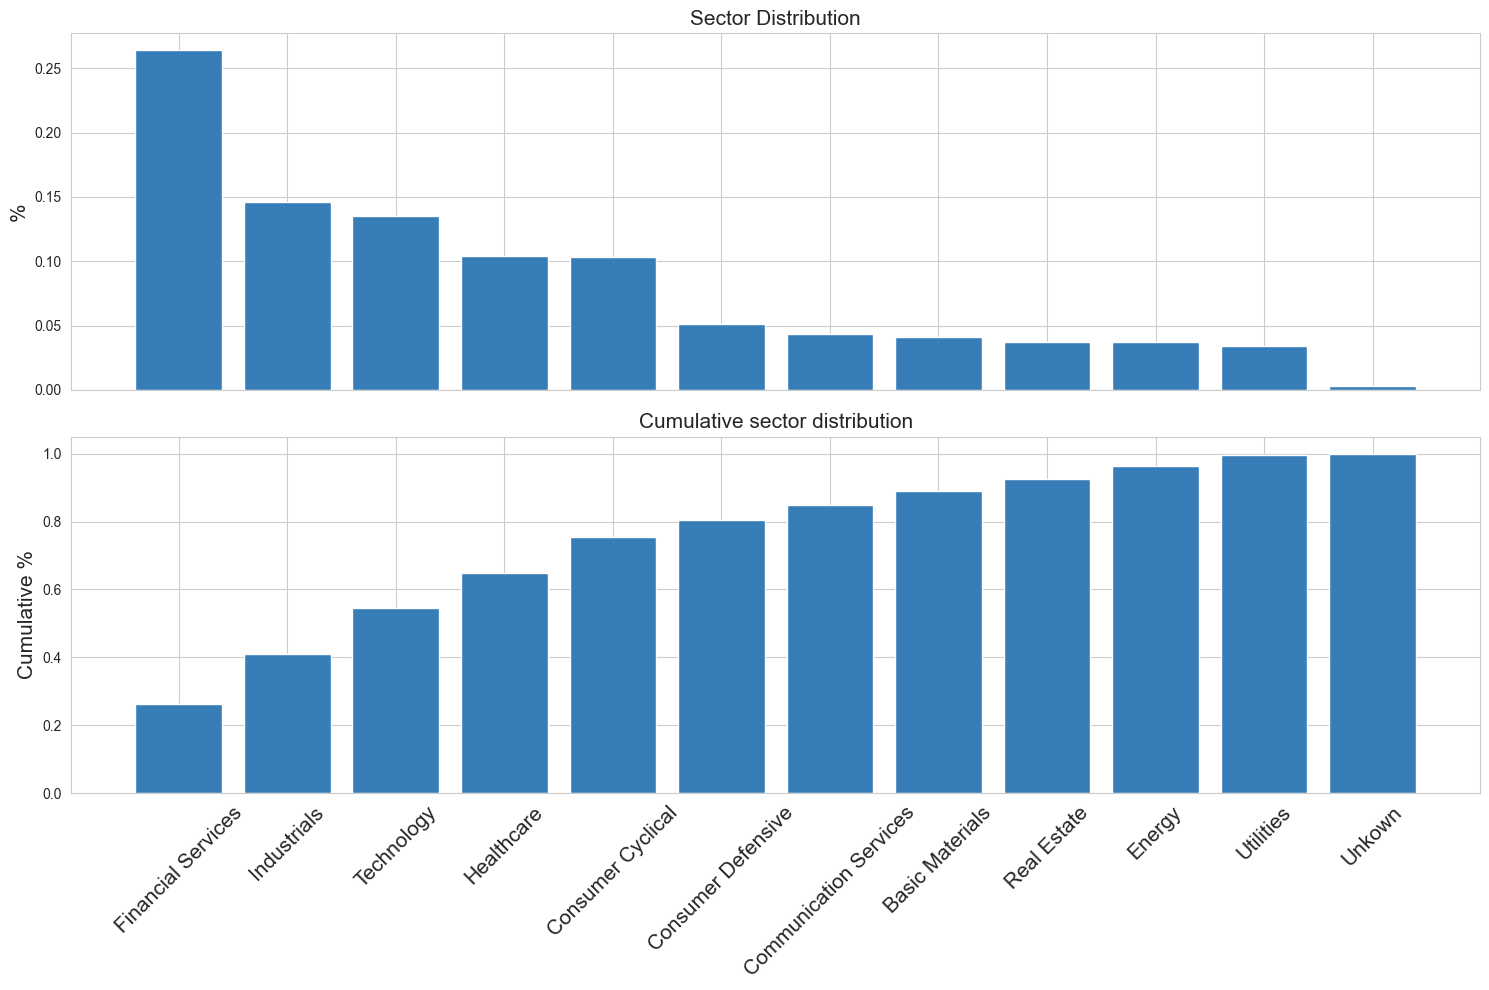

In [8]:
index_ = (df_model.groupby('sector').count()['revenue'] / len(df_model)).sort_values(ascending=False).index
to_plot = pd.DataFrame(index = index_)
to_plot['%_sectors'] = (df_model.groupby('sector').count()['revenue'] / len(df_model)).sort_values(ascending=False)
to_plot['cumulative_%'] = (df_model.groupby('sector').count()['revenue'] / len(df_model)).sort_values(ascending=False).cumsum()

plt.figure(figsize=(20, 10))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

ax1.bar(height=to_plot['%_sectors'], x=to_plot.index,color = palette[1])
ax1.set_xticklabels(to_plot.index, rotation=45, size=15)

ax2.bar(height=to_plot['cumulative_%'], x=to_plot.index,color = palette[1])
ax2.set_xticklabels(to_plot.index, rotation=45, size=15)

ax1.set_title('Sector Distribution',size = 15)
ax2.set_title('Cumulative sector distribution',size = 15)

ax1.set_ylabel('%',size = 15)
ax2.set_ylabel('Cumulative %',size = 15)
plt.tight_layout()

title = 'SectorDistribution'

name_plot = f'{path}\\{title}.png'
plt.savefig(name_plot, dpi=300)
plt.show()


<Figure size 1440x720 with 0 Axes>

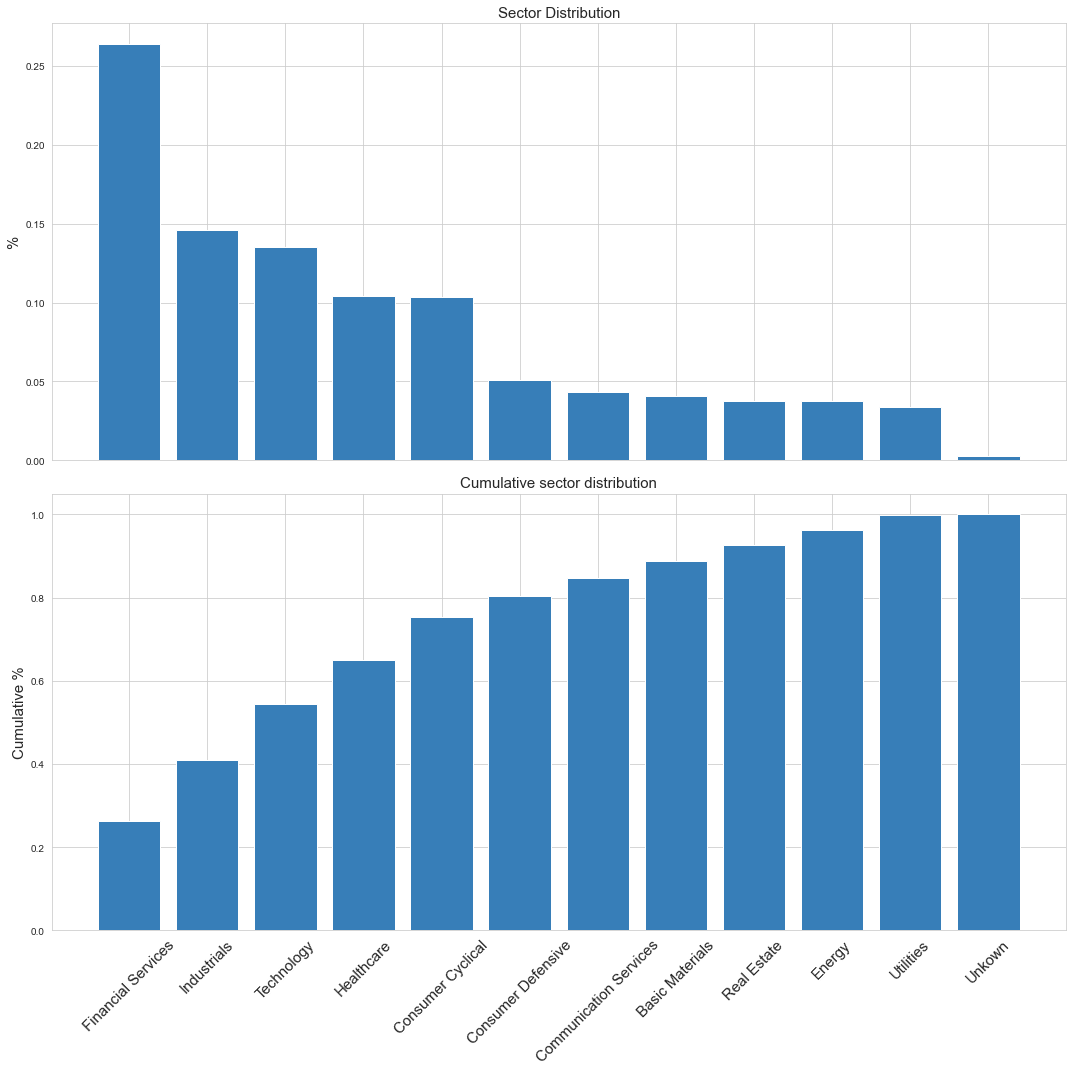

In [8]:
plt.figure(figsize=(20, 10))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), sharex=True)

ax1.bar(height=to_plot['%_sectors'], x=to_plot.index,color = palette[1])
ax1.set_xticklabels(to_plot.index, rotation=45, size=15)

ax2.bar(height=to_plot['cumulative_%'], x=to_plot.index,color = palette[1])
ax2.set_xticklabels(to_plot.index, rotation=45, size=15)

ax1.set_title('Sector Distribution',size = 15)
ax2.set_title('Cumulative sector distribution',size = 15)

ax1.set_ylabel('%',size = 15)
ax2.set_ylabel('Cumulative %',size = 15)
plt.tight_layout()

title = 'SectorDistribution'
path = r'D:\Desktop\Long-Term-Model\Exports\CAPM\Exploration'
name_plot = f'{path}\\{title}.png'
# plt.savefig(name_plot, dpi=300)

plt.show()


## Target Creation

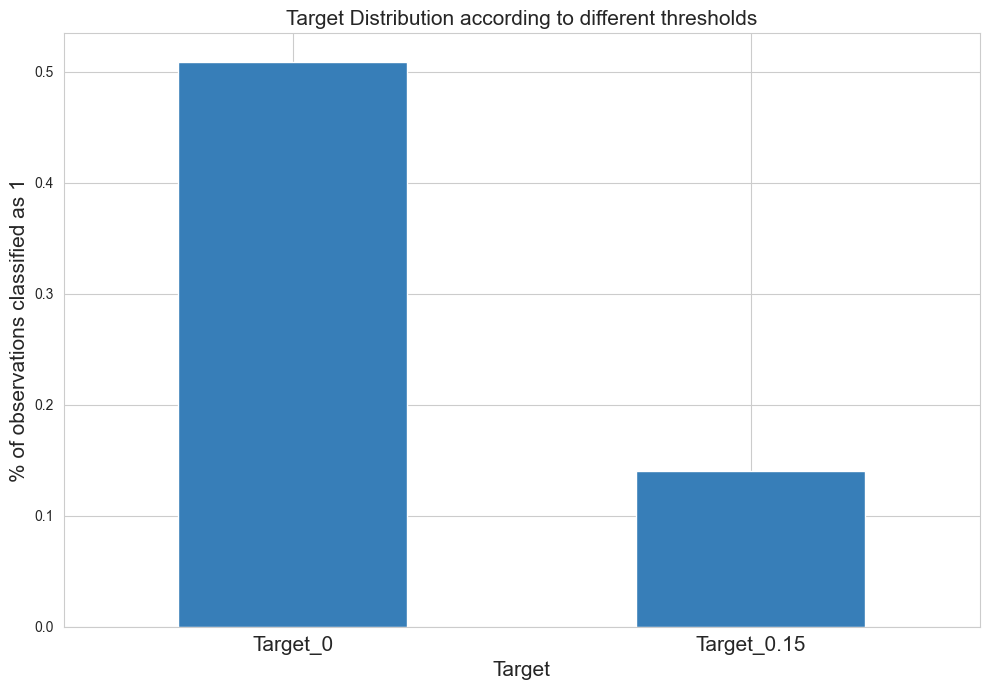

In [13]:
size = 15
title = 'Target Distribution according to different thresholds'

df_target_ = df_model[['Target_0','Target_0.15']]
df_target_.iloc[:,:].mean().plot.bar(figsize = (10,7),color = palette[1])
plt.xticks(rotation=0, size = size)
plt.ylabel('% of observations classified as 1', size = size)
plt.title(title, size = size)
plt.xlabel('Target', size = size )


plt.tight_layout()

name_plot = f'{path}\\{title}.png'
plt.savefig(name_plot, dpi=300)

## Returns Evolution Over time 

### Returns per quarter

On average the market growth 0.034868851477965715% each quarter


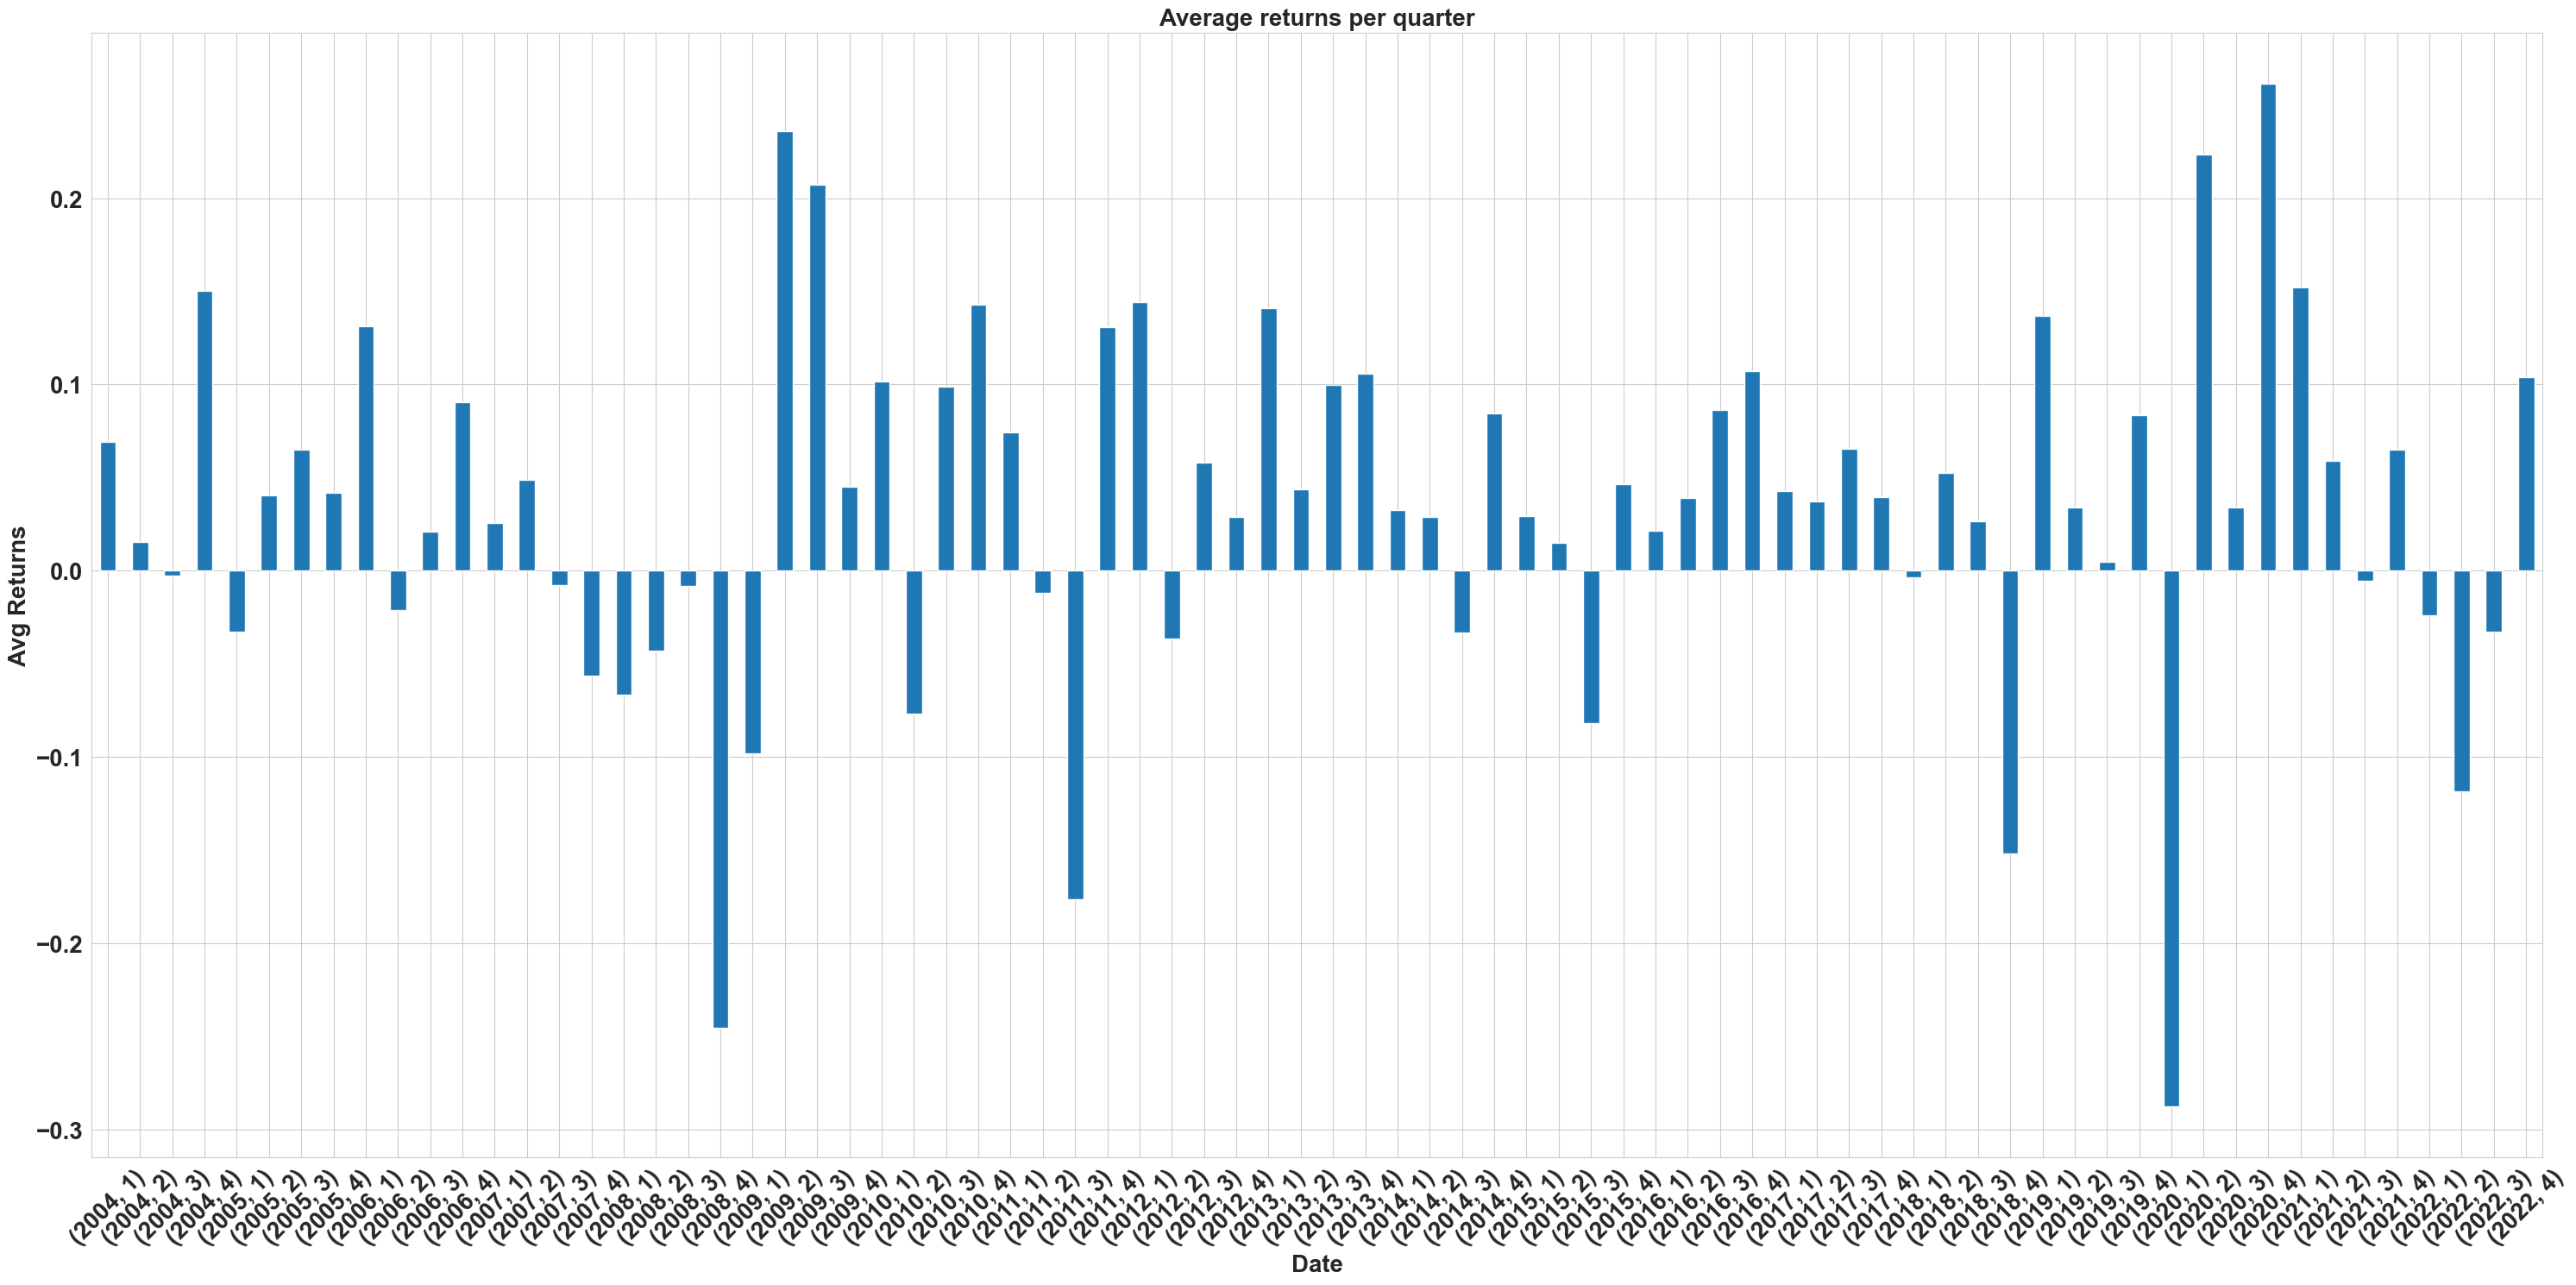

In [28]:
query = """

SELECT *
FROM `stockmarket-v0.stockMarket_dev.QuarterlyPrices` 
"""
projectID = 'stockmarket-v0'

# daily_resample = pd.read_gbq(query = query, project_id = projectID)

quarterly_returns = daily_resample.sort_values('date').set_index(['symbol','year','Quarter',]).groupby('symbol')['adjClose'].pct_change()
quarterly_returns = quarterly_returns.loc[(quarterly_returns.index.get_level_values(1)>=2004)&
                                          (quarterly_returns.index.get_level_values(1)<2023)]

tickers = df_model.index.get_level_values(0)
quarterly_returns = quarterly_returns.loc[quarterly_returns.index.get_level_values(0).isin(tickers)]

quarterly_returns = quarterly_returns.loc[quarterly_returns.values<1.5]

to_plot = quarterly_returns.groupby(['year','Quarter']).mean()
size = 20
title = 'Average returns per quarter'
to_plot.plot.bar(figsize = (30,15))
plt.xticks(rotation = 45, size = size,weight = 'bold')
plt.yticks( size = size,weight = 'bold')
plt.title(title, size = size,weight = 'bold')
plt.xlabel('Date',size = size,weight = 'bold')
plt.ylabel('Avg Returns',size = size,weight = 'bold')
plt.tight_layout()

name_plot = f'{path}\\{title}.png'
plt.savefig(name_plot, dpi=600)

avg_quarter_returns = quarterly_returns.groupby(['year','Quarter']).mean().mean()
print(f'On average the market growth {avg_quarter_returns}% each quarter')

### Avg Returns per year

NameError: name 'size' is not defined

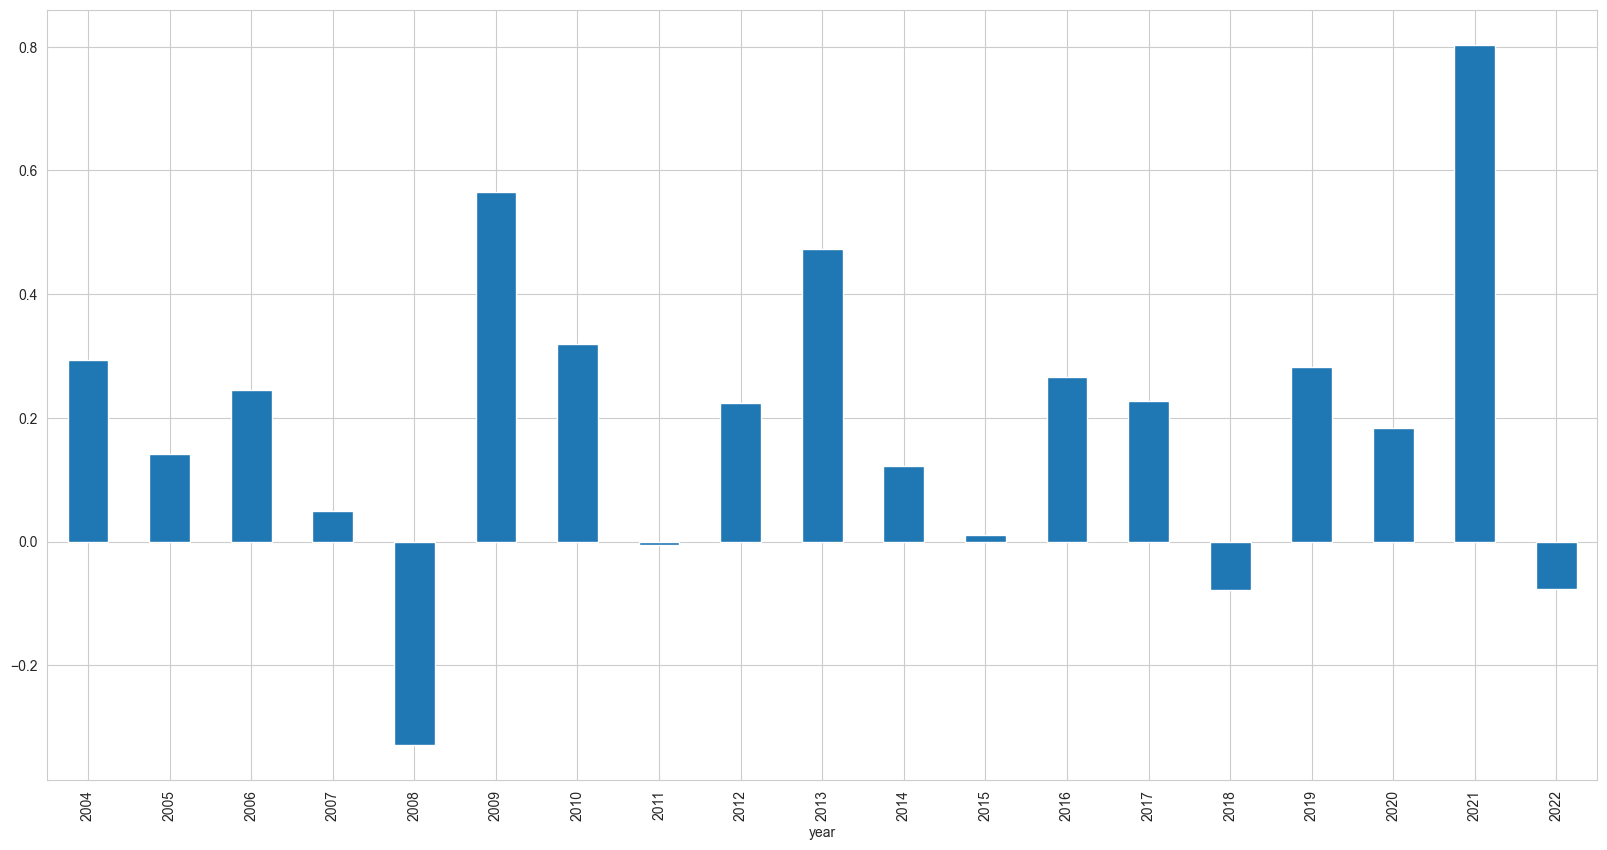

In [3]:
query = """

SELECT *
FROM `stockmarket-v0.stockMarket_dev.QuarterlyPrices` 
"""
projectID = 'stockmarket-v0'

daily_resample = pd.read_gbq(query = query, project_id = projectID)

quarterly_returns = daily_resample.groupby(['symbol','year']).agg('last').groupby('symbol')['adjClose'].pct_change()
quarterly_returns = quarterly_returns.loc[(quarterly_returns.index.get_level_values(1)>=2004)&
                                          (quarterly_returns.index.get_level_values(1)<2023)]

tickers = df_model.index.get_level_values(0)
quarterly_returns = quarterly_returns.loc[quarterly_returns.index.get_level_values(0).isin(tickers)]

# quarterly_returns = quarterly_returns.loc[quarterly_returns.values<1.5]

to_plot =  quarterly_returns.groupby(['year',]).mean()

title = 'Average returns per year'
to_plot.plot.bar(figsize = (20,10))
plt.xticks(rotation = 0, size = size,weight = 'bold')
plt.yticks(size = size,weight = 'bold')
plt.title(title, size = size,weight = 'bold')
avg_returns = np.round(to_plot.mean(),3)*100
plt.xlabel('Date',size = size,weight = 'bold')
plt.ylabel('Avg Returns',size = size,weight = 'bold')
print(f'Average Returns per year: {avg_returns} %')
plt.tight_layout()

name_plot = f'{path}\\{title}.png'
# plt.savefig(name_plot, dpi=600)

display(to_plot)

Average Returns per year: 11.4 %


year
2004    0.206188
2005    0.086811
2006    0.198896
2007    0.010556
2008   -0.331190
2009    0.281292
2010    0.244812
2011   -0.028580
2012    0.175454
2013    0.391737
2014    0.099244
2015    0.004002
2016    0.245210
2017    0.177896
2018   -0.088487
2019    0.252168
2020    0.080353
2021    0.249385
2022   -0.084146
Name: adjClose, dtype: float64

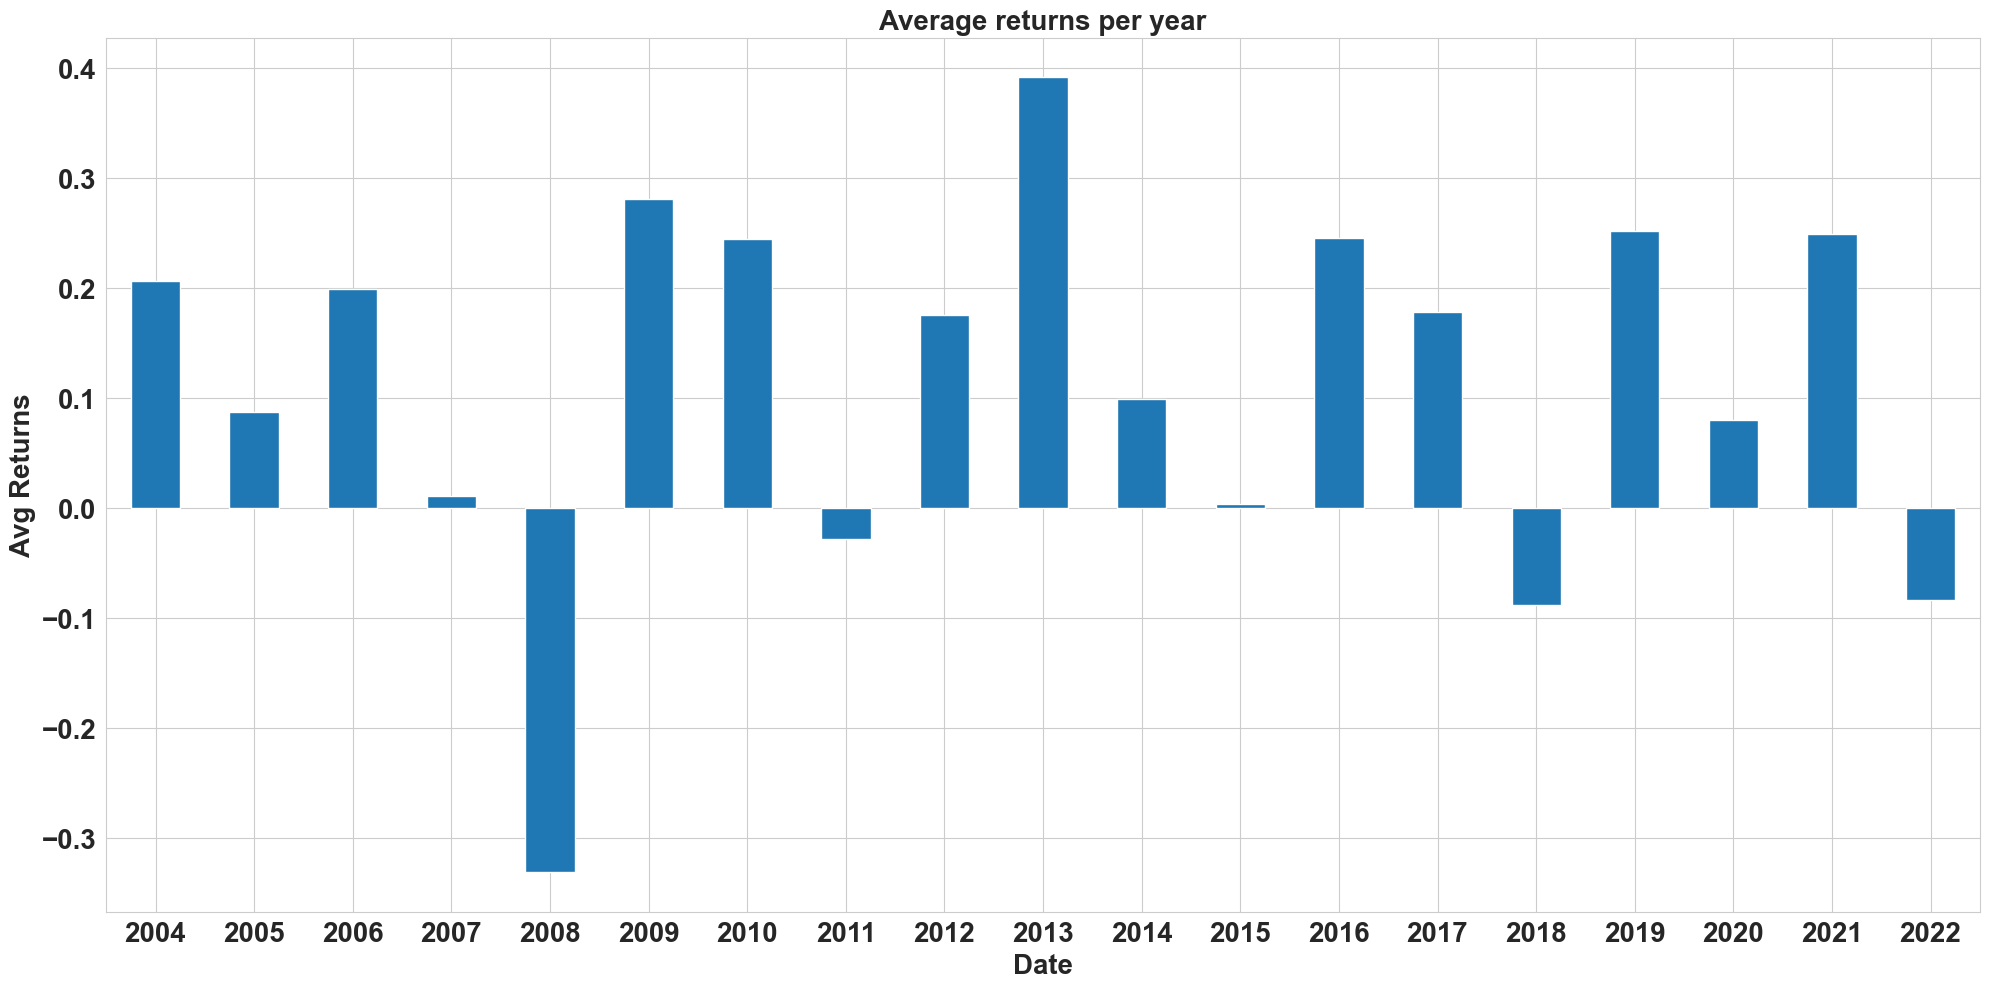

In [27]:
query = """

SELECT *
FROM `stockmarket-v0.stockMarket_dev.QuarterlyPrices` 
"""
projectID = 'stockmarket-v0'

daily_resample = pd.read_gbq(query = query, project_id = projectID)

quarterly_returns = daily_resample.groupby(['symbol','year']).agg('last').groupby('symbol')['adjClose'].pct_change()
quarterly_returns = quarterly_returns.loc[(quarterly_returns.index.get_level_values(1)>=2004)&
                                          (quarterly_returns.index.get_level_values(1)<2023)]

tickers = df_model.index.get_level_values(0)
quarterly_returns = quarterly_returns.loc[quarterly_returns.index.get_level_values(0).isin(tickers)]

# quarterly_returns = quarterly_returns.loc[quarterly_returns.values<1.5]

to_plot =  quarterly_returns.groupby(['year',]).mean()

title = 'Average returns per year'
to_plot.plot.bar(figsize = (20,10))
plt.xticks(rotation = 0, size = size,weight = 'bold')
plt.yticks(size = size,weight = 'bold')
plt.title(title, size = size,weight = 'bold')
avg_returns = np.round(to_plot.mean(),3)*100
plt.xlabel('Date',size = size,weight = 'bold')
plt.ylabel('Avg Returns',size = size,weight = 'bold')
print(f'Average Returns per year: {avg_returns} %')
plt.tight_layout()

name_plot = f'{path}\\{title}.png'
# plt.savefig(name_plot, dpi=600)

display(to_plot)